### This notebook is to explore and develop functionality to output our downsampled imagery as COGeoTIFF

In [1]:
import os
import sys
from pathlib import Path


module_path = os.path.abspath(os.path.join('..')) # add the projects src code directory to the sys path to allow finding our module
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\data")
    #sys.path.insert(0, module_path+"\\src\\data")
    
import downSampler # load pipeline module

In [2]:
# other useful libraries

import json
import h5py
import gdal
gdal.UseExceptions()
import itertools
import pystac
import geojson as gj
import numpy as np

### Lets look at our generated file

In [3]:
input_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files

In [4]:
input_file_dict  = downSampler.find_files(input_data_path)
input_file_dict

Finding data files...


{'NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5072000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\\NEON_D16_ABBY_DP3_552000_5073000_reflectance.h5',
 'NEON_D16_ABBY_DP3_552000_5074000_reflectance.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.

In [5]:
output_file_dict = downSampler.find_files(output_data_path)
output_file_dict

Finding data files...


{'cube_output_TEST_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\cube_output_TEST_1.h5',
 'splitbands_output_TEST_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_1.h5',
 'splitbands_output_TEST_2.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_2.h5',
 'TEST_output_1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\TEST_output_1.h5',
 'TEST_output_Geo1.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\TEST_output_Geo1.h5',
 'Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5': 'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\hdf5_downsampled\\Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5',
 'Wyvern_D10_RMNP_

### Check the input data structure

In [8]:
in_keys_ls = list(input_file_dict.keys())
in_keys_ls
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(input_file_dict[in_keys_ls[0]])

	 - ABBY : <HDF5 group "/ABBY" (1 members)>
		 - Reflectance : <HDF5 group "/ABBY/Reflectance" (2 members)>
			 - Metadata : <HDF5 group "/ABBY/Reflectance/Metadata" (7 members)>
				 - Ancillary_Imagery : <HDF5 group "/ABBY/Reflectance/Metadata/Ancillary_Imagery" (14 members)>
					 - Aerosol_Optical_Depth : <HDF5 dataset "Aerosol_Optical_Depth": shape (1000, 1000), type "<i2">
							 - Band_Names : b'AOT (aerosol optical thickness at 550 nm)*1000'
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aerosol Optical Depth at 500 nm.'
							 - Scale_Factor : 1000.0
							 - Units : b'Aerosol Optical Depth at 500 nm.'
					 - Aspect : <HDF5 dataset "Aspect": shape (1000, 1000), type "<f4">
							 - Data_Ignore_Value : -9999.0
							 - Description : b'Aspect used as input to ATCOR'
							 - Dimension_Labels : b'-'
							 - Scale_Factor : 1.0
							 - Units : b'degrees'
					 - Cast_Shadow : <HDF5 dataset "Cast_Shadow": shape (1000, 1000), type "|u1">
							 - Data_Ign

In [9]:
out_keys_ls = list(output_file_dict.keys())
out_keys_ls
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(output_file_dict[out_keys_ls[1]])

	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 505.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_002 : <HDF5 dataset "Band_002": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 526.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_003 : <HDF5 dataset "Band_003": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 544.0
				 

### Dig into Coordinate Reference System

In [10]:
print('Filename: ', in_keys_ls[0])
print('Path: ', input_file_dict[in_keys_ls[0]])

f = h5py.File(input_file_dict[in_keys_ls[0]], 'r') # read in file

Filename:  NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5
Path:  C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_input\NEON.D16.ABBY.DP3.30006.001.2019-07.basic.20210211T072435Z.RELEASE-2021\NEON_D16_ABBY_DP3_552000_5071000_reflectance.h5


In [11]:
Coordinate_System = f['ABBY']['Reflectance']['Metadata']['Coordinate_System']
Coordinate_System.keys()

<KeysViewHDF5 ['Coordinate_System_String', 'EPSG Code', 'Map_Info', 'Proj4']>

In [12]:
# look at what is in the coordinate system string:
print(Coordinate_System['Coordinate_System_String'].shape)
print(Coordinate_System['Coordinate_System_String'].dtype)
Coordinate_System['Coordinate_System_String'][()]

()
object


b'PROJCS["UTM_Zone_10N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-123.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'

In [13]:
# look at what is in the EPSG Code:
print(Coordinate_System['EPSG Code'].shape)
print(Coordinate_System['EPSG Code'].dtype)
Coordinate_System['EPSG Code'][()]

()
object


b'32610'

In [14]:
# look at what is in the Map Info:
print(Coordinate_System['Map_Info'].shape)
print(Coordinate_System['Map_Info'].dtype)
Coordinate_System['Map_Info'][()]

()
object


b'UTM,  1.000,  1.000,       552000.00,       5072000.0,       1.0000000,       1.0000000,  10,  North,  WGS-84,  units=Meters, 0'

In [15]:
# look at what is in the Proj4:
print(Coordinate_System['Proj4'].shape)
print(Coordinate_System['Proj4'].dtype)
Coordinate_System['Proj4'][()]

()
object


b'+proj=UTM +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

Looks like we can use this Proj4 with GDAL to help convert to Lon,Lat used in STAC spec

## Array to hdf5 raster layer image:

In [10]:
# work on the output function

def array2h5raster(refl_array, wavelength_array, FWHM_array, metadata_dict, filename_output):
    """
    Takes in a 3-D reflectance array, an array of band centre wavelengths, FWHM array,
    and an additional metadata dictionary and generates a HDF5 file with the given filename.
    """

    # scale the reflectance data up by the original reflectance factor to save disk space
    scale_fac = metadata_dict['reflectance scale factor']
    refl_array = refl_array*scale_fac

    hf = h5py.File(filename_output, 'w') # create hdf5 file
    g1 = hf.create_group('Reflectance') # create main group
    g2 = hf.create_group('Reflectance/Metadata') # group for metadata

    # datasets
    # ------------------------------------------------------------------------------
    # reflectance data
    
    for band in range(refl_array.shape[2]):
        #print("band",band)
        band_name = 'Band_' + str(band+1).zfill(3) # make into e.g. 001 or 013 instead of 1 or 13 etc.
        print(band_name)
        refl_dset = g1.create_dataset(band_name,data=refl_array[:,:,band], dtype='i') # dataset for each band of reflectance data
        refl_dset.attrs['Description'] =  'Atmospherically corrected reflectance.'
        refl_dset.attrs['Wavelength'] = wavelength_array[band]*1000 # wavelength in nm
        refl_dset.attrs['Wavelength_units'] = 'nm' # wavelength units
        refl_dset.attrs['data ignore value'] = metadata_dict['data ignore value']
        refl_dset.attrs['reflectance scale factor'] = metadata_dict['reflectance scale factor']
        refl_dset.attrs['Spatial_Resolution_X_Y'] = metadata_dict['Spatial_Resolution_X_Y']
        refl_dset.attrs['spatial extent'] = metadata_dict['spatial extent']

    # wavelength data
    wav_dset = g2.create_dataset('Wavelength',data=wavelength_array) # band centre wavelength data
    wav_dset.attrs['Description'] = 'Central wavelength of the reflectance bands.'
    wav_dset.attrs['Units'] = 'nanometers'

    # FWHM data
    FWHM_dset = g2.create_dataset('FWHM',data=FWHM_array) # FWHM data
    FWHM_dset.attrs['Description'] = 'Full width half maximum of reflectance bands.'
    FWHM_dset.attrs['Units'] = 'nanometers'

    # coordinates data
    g2_1 = g2.create_group('Coordinate_System') # group for metadata
    Proj4_dset = g2_1.create_dataset('Proj4',data=metadata_dict['Proj4']) # band Proj4 data
    EPSG_dset = g2_1.create_dataset('EPSG Code',data=metadata_dict['EPSG Code']) # EPSG Code
    map_dset = g2_1.create_dataset('Map_Info',data=metadata_dict['Map_Info']) # Map Info
    coor_dset = g2_1.create_dataset('Coordinate_System_String',data=metadata_dict['Coordinate_System_String']) # coordinate system
    map_dset.attrs['Description'] = ("List of geographic information in the following order:\n"
                                    "   - Projection name\n"
                                    "   - Reference (tie point) pixel x location (in file coordinates)\n"
                                    "   - Reference (tie point) pixel y location (in file coordinates)\n"
                                    "   - Pixel easting\n"
                                    "   - Pixel northing\n"
                                    "   - x pixel size\n"
                                    "   - y pixel size\n"
                                    "   - Projection zone (UTM only)\n"
                                    "   - North or South (UTM only)\n"
                                    "   - Datum\n"
                                    "   - Units\n"
                                    "   - Rotation Angle\n"
                                    )
    
    #     - Description : List of geographic information in the following order: 
    #         - Projection name
    #         - Reference (tie point) pixel x location (in file coordinates)
    #         - Reference (tie point) pixel y location (in file coordinates)
    #         - Pixel easting
    #         - Pixel northing
    #         - x pixel size
    #         - y pixel size
    #         - Projection zone (UTM only)
    #         - North or South (UTM only)
    #         - Datum
    #         - Units
    #         - Rotation Angle
    
    hf.close() # close file to save and write to disk


In [11]:
refl_array, wavelength_array, FWHM_array, metadata_dict = downSampler.h5data2array(input_file_dict[in_keys_ls[5]])

In [12]:
metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': array([1., 1.]),
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.

In [14]:
# parameter setup:
data_dir_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_input' # path to input data files
output_data_path = Path(os.getcwd()).parents[0] / 'data' / 'pipeline_output' # path to input data files
desired_GSD = 5 # GSD in m
desired_band_centres = [0.505, 0.526, 0.544, 0.565, 0.586, 0.606, 0.626, 0.646, 0.665, 0.682, 0.699, 0.715, 0.730, 0.745, 0.762, 0.779, 0.787, 0.804]
print("Parameters set!")

Parameters set!


In [63]:
# perform downsampling
resamp_refl_array = downSampler.downSample_reband_array(refl_array, metadata_dict['Spatial_Resolution_X_Y'][0], desired_GSD, wavelength_array, desired_band_centres) # downsample
resamp_metadata_dict = metadata_dict.copy()
resamp_metadata_dict['Spatial_Resolution_X_Y'] = [float(desired_GSD), float(desired_GSD)] # adjust resolution metadata to reflect downsampling
print("Downsampling Complete!")

Downsampling Complete!


In [64]:
resamp_refl_array.shape

(1000, 1000, 18)

In [65]:
resamp_metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': [5.0, 5.0],
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.9996]

### Start error checking code

In [26]:
input_file_dict[in_keys_ls[5]]

'C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_input\\NEON_refl-surf-dir-ortho-mosaic\\NEON.D10.RMNP.DP3.30006.001.2018-09.basic.20210401T092346Z.RELEASE-2021\\NEON_D10_RMNP_DP3_459000_4448000_2018_reflectance.h5'

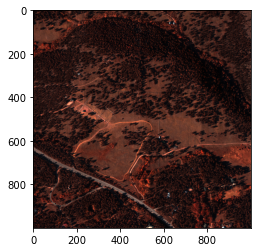

In [66]:
downSampler.toRGB(refl_array, 'QA_vis1.png', mode=1)

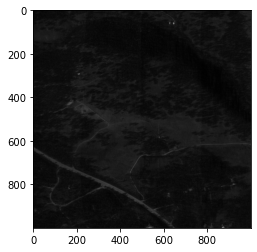

In [67]:
downSampler.toRGB(resamp_refl_array, 'QA_vis2.png', mode=2)

In [17]:
refl_array[:,:,0]

array([[0.0126, 0.0223, 0.018 , ..., 0.0336, 0.0413, 0.0504],
       [0.0169, 0.0147, 0.0137, ..., 0.0434, 0.0374, 0.0452],
       [0.0117, 0.0185, 0.0171, ..., 0.0341, 0.0405, 0.0423],
       ...,
       [0.014 , 0.0095, 0.018 , ..., 0.011 , 0.0157, 0.0169],
       [0.0165, 0.0096, 0.0069, ..., 0.0133, 0.0208, 0.0183],
       [0.0089, 0.0127, 0.0101, ..., 0.0138, 0.0131, 0.0148]])

In [56]:
resamp_refl_array[:,:,5]

array([[0.013136, 0.013928, 0.01472 , ..., 0.04004 , 0.040072, 0.040104],
       [0.013288, 0.014124, 0.01496 , ..., 0.04012 , 0.040096, 0.040072],
       [0.01344 , 0.01432 , 0.0152  , ..., 0.0402  , 0.04012 , 0.04004 ],
       ...,
       [0.0135  , 0.0132  , 0.0129  , ..., 0.0157  , 0.0153  , 0.0149  ],
       [0.013132, 0.012816, 0.0125  , ..., 0.01542 , 0.015104, 0.014788],
       [0.012764, 0.012432, 0.0121  , ..., 0.01514 , 0.014908, 0.014676]])

In [57]:
# resampled input image
for band in range(resamp_refl_array.shape[2]):
    print('Band: ', band)
    print('Max: ', resamp_refl_array[:,:,band].max())
    print('Min: ', resamp_refl_array[:,:,band].min())
    print('Avg.: ', np.average(resamp_refl_array[:,:,band]))
    print('Std.: ', np.std(resamp_refl_array[:,:,band]))

Band:  0
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  1
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  2
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  3
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  4
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  5
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  6
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  7
Max:  0.16449999999999762
Min:  0.0024000000000001507
Avg.:  0.023460247100000012
Std.:  0.010162367429853205
Band:  8
Max:  0.16449999999999762
Min:  0.00240

In [23]:
np.round(resamp_refl_array[:,:,0],4)

array([[0.0131, 0.0139, 0.0147, ..., 0.04  , 0.0401, 0.0401],
       [0.0133, 0.0141, 0.015 , ..., 0.0401, 0.0401, 0.0401],
       [0.0134, 0.0143, 0.0152, ..., 0.0402, 0.0401, 0.04  ],
       ...,
       [0.0135, 0.0132, 0.0129, ..., 0.0157, 0.0153, 0.0149],
       [0.0131, 0.0128, 0.0125, ..., 0.0154, 0.0151, 0.0148],
       [0.0128, 0.0124, 0.0121, ..., 0.0151, 0.0149, 0.0147]])

In [ ]:
np.round(resamp_refl_array[:,:,0],4)

### End error checking code

In [18]:
# save to raster hdf5
refl_arrayname_output =  Path(output_data_path / 'splitbands_output_TEST_1.h5')
band_width_array = downSampler.band_widths(desired_band_centres)
array2h5raster(resamp_refl_array, desired_band_centres, band_width_array, metadata_dict, refl_arrayname_output)

Band_001
Band_002
Band_003
Band_004
Band_005
Band_006
Band_007
Band_008
Band_009
Band_010
Band_011
Band_012
Band_013
Band_014
Band_015
Band_016
Band_017
Band_018


In [20]:
# test outputted file
#Path("C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5")
downSampler.h5dump(refl_arrayname_output)

	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 505.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_002 : <HDF5 dataset "Band_002": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 526.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - Band_003 : <HDF5 dataset "Band_003": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 544.0
				 

In [22]:
print(out_keys_ls)
# next(iter(input_file_dict)) alternative way
downSampler.h5dump(output_file_dict[out_keys_ls[1]])

['cube_output_TEST_1.h5', 'splitbands_output_TEST_1.h5', 'splitbands_output_TEST_2.h5', 'TEST_output_1.h5', 'TEST_output_Geo1.h5', 'Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5', 'Wyvern_D10_RMNP_DP3_459000_4448000_2018_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5071000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5072000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5073000_reflectance_downsampled_4mGSD.h5', 'Wyvern_D16_ABBY_DP3_552000_5074000_reflectance_downsampled_4mGSD.h5']
	 - Reflectance : <HDF5 group "/Reflectance" (19 members)>
		 - Band_001 : <HDF5 dataset "Band_001": shape (1000, 1000), type "<i4">
				 - Description : Atmospherically corrected reflectance.
				 - Spatial_Resolution_X_Y : [4. 4.]
				 - Wavelength : 505.0
				 - Wavelength_units : nm
				 - data ignore value : -9999.0
				 - reflectance scale factor : 10000.0
				 - spatial extent : [ 459000.  460000. 4448000. 4449000.]
		 - B

In [19]:
# write out hdf5 cube file for testing in gdal
refl_arrayname_output =  Path(output_data_path / 'cube_output_TEST_1.h5')
downSampler.array2h5data(resamp_refl_array, desired_band_centres, band_width_array, metadata_dict, refl_arrayname_output)

### Now write out a GeoTIFF (Method #1 - gdal.translate on HDF5 file):

In [47]:
from osgeo import gdal
gdal.UseExceptions()

kwargs = {
        'format': 'GTiff',
        #'outputSRS' : '+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378140 +b=6356750 +x_0=0 y_0=0',
        #'outputSRS' : '+proj=UTM +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
        #'outputBounds' : [0.0, -3649999.1798970395, 700000.9100000001, -4415003.157897039]
        #'outputBounds' : [0.0, -3649999.1798970395, 700000.9100000001, -4415003.157897039]
        }

# could get this working with a loop and CRS system

#Wyvern_D10_RMNP_DP3_459000_4448000_2017_reflectance_downsampled_4mGSD.h5

#fn = 'HDF5:\"RAD_NL25_PCP_NA_202101080825.h5\"://image1/image_data'
#refl_arrayname_output =  Path(output_data_path / 'cube_output_TEST_1.h5')
refl_arrayname_output =  Path(output_data_path / 'splitbands_output_TEST_2.h5')
fn = r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\splitbands_output_TEST_1.h5"://Reflectance/Band_001'
dst_fn = 'geotiff_method1_TEST_output.tif'

outdata = gdal.Translate(dst_fn, fn, **kwargs)

outdata.FlushCache() # save to disk

outdata = None


# ds=None
# try:
#     ds = gdal.Open(r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\splitbands_output_TEST_1.h5"')
# except RuntimeError, err:
#     print "Exception: ", err
#     exit(1)

# gdal_translate your_HDF_file -sds output.tif # The -sds option will split your multiband HDF5 file into multiple single band tif files.

### Now write out a GeoTIFF (Method #2  - write .tiff file out directly from numpy array into one Geotiff with multiple raster layers): - Also potentially promising

In [28]:
# Good SO answer here: https://gis.stackexchange.com/questions/164853/reading-modifying-and-writing-a-geotiff-with-gdal-in-python
#output_data_path
from osgeo import gdal
gdal.UseExceptions()
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
#outFileName = 'geotiff_method2_TEST_output2.tif'
band_num = len(resamp_refl_array[0,0,:])
NO_DATA = -9999
dtype = gdal.GDT_Float32


driver = gdal.GetDriverByName('GTiff')

#outdata.SetProjection("EPSG:4326")

new_raster_fn = 'geotiff_method2_TEST_output1.tif'
out_raster = driver.Create(new_raster_fn, cols, rows, band_num, dtype)

for band in range(band_num):
    band_name = 'Band_' + str(band+1).zfill(3) # make into e.g. 001 or 013 instead of 1 or 13 etc.
    print(band_name)

    outband = out_raster.GetRasterBand(band+1)#band_num)
    outband.WriteArray(resamp_refl_array[:,:,band])
    outband.SetNoDataValue(NO_DATA)
    outband.FlushCache()
    outband = None
    
#out_raster.FlushCache() # save to disk


out_raster = None
    

#output_dir = os.path.dirname(new_rasterf_fn)
#if not os.path.isdir(output_dir):
#     try:
#         os.mkdir(output_dir)
#     except OSError:
#         print('Creating directory failed')
#         #logging.info(">>>>>> Creation of the directory {} failed".format(output_dir))
#     else:
#         print('Creating directory succeded')
#         #logging.info(">>>>>> Successfully created the directory {}".format(output_dir))

#origin_x, pixel_width, b, origin_y, d, pixel_height = (0, 1, 0, 0, 0, 0) #(upper_left_x, x_resolution, x_skew, upper_left_y, y_skew, y_resolution) # dataset.GetGeoTransform()
        
#'UTM,  1.000,  1.000,       552000.00,       5072000.0,       1.0000000,       1.0000000,  10,  North,  WGS-84,  units=Meters, 0'
   #         - Projection name
    #         - Reference (tie point) pixel x location (in file coordinates)
    #         - Reference (tie point) pixel y location (in file coordinates)
    #         - Pixel easting
    #         - Pixel northing
    #         - x pixel size
    #         - y pixel size
    #         - Projection zone (UTM only)
    #         - North or South (UTM only)
    #         - Datum
    #         - Units
    #         - Rotation Angle
    

        
#for band in range(2): #len(resamp_refl_array[0,0,:])):






# clean up to free memory
#outdata = None
#band=None
#ds=None

# The "1" in driver.Create() indicates the number of bands. Then you can write on each band with outdata.GetRasterBand(band_number). It starts at 1, not zero.

Band_001
Band_002
Band_003
Band_004
Band_005
Band_006
Band_007
Band_008
Band_009
Band_010
Band_011
Band_012
Band_013
Band_014
Band_015
Band_016
Band_017
Band_018


### Now write out a GeoTIFF (Method #3 - Write out each band as separate .tiff file): THIS ONE

In [54]:
os.path.join(file_path, band_name)

'..\\data\\Skywatch\\catalog\\geotiff\\geotiff_method3_TEST_output Band_018.tif'

In [30]:
from osgeo import gdal
gdal.UseExceptions()
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
#outFileName = 'geotiff_method2_TEST_output2.tif'
num_bands = resamp_refl_array.shape[2]
NO_DATA = -9999
dtype = gdal.GDT_Float32


driver = gdal.GetDriverByName('GTiff')

file_path = r"..\data\Skywatch\catalog"

for band in range(num_bands):
    band_name =  'geotiff_method3_TEST_output Band_' + str(band+1).zfill(3) + '.tif' # make into e.g. 001 or 013 instead of 1 or 13 etc.
    print(band_name)
    
    full_path = str(os.path.join(file_path, band_name)) # gdal can't seem to handle filepaths
    
    #out_raster = driver.Create(band_name, cols, rows, 1, dtype)
    out_raster = driver.Create(full_path, cols, rows, 1, dtype)
    out_raster.SetProjection("EPSG:32610") # might need to change this later
    outband = out_raster.GetRasterBand(1)
    outband.WriteArray(resamp_refl_array[:,:,band])
    outband.SetNoDataValue(NO_DATA)
    outband.FlushCache()
    outband = None
    out_raster = None
# #out_raster.FlushCache() # save to disk


     
    

geotiff_method3_TEST_output Band_001.tif
geotiff_method3_TEST_output Band_002.tif
geotiff_method3_TEST_output Band_003.tif
geotiff_method3_TEST_output Band_004.tif
geotiff_method3_TEST_output Band_005.tif
geotiff_method3_TEST_output Band_006.tif
geotiff_method3_TEST_output Band_007.tif
geotiff_method3_TEST_output Band_008.tif
geotiff_method3_TEST_output Band_009.tif
geotiff_method3_TEST_output Band_010.tif
geotiff_method3_TEST_output Band_011.tif
geotiff_method3_TEST_output Band_012.tif
geotiff_method3_TEST_output Band_013.tif
geotiff_method3_TEST_output Band_014.tif
geotiff_method3_TEST_output Band_015.tif
geotiff_method3_TEST_output Band_016.tif
geotiff_method3_TEST_output Band_017.tif
geotiff_method3_TEST_output Band_018.tif


In [ ]:
# REFERENCE FUNCTION
# def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

#     cols = array.shape[1]
#     rows = array.shape[0]
#     originX = rasterOrigin[0]
#     originY = rasterOrigin[1]

#     driver = gdal.GetDriverByName('GTiff')
#     outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
#     outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
#     outband = outRaster.GetRasterBand(1)
#     outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromEPSG(4326)
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
#     outband.FlushCache()

### Now write out a GeoTIFF (Method #4 - open the hdf5 file with gdal, read bands and write out):

In [43]:
# from osgeo import gdal
# dataset = gdal.Open(r'HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5"')
# dataset
from osgeo import gdal
gdal.UseExceptions()
#driver = gdal.GetDriverByName('HDF5')
#driver.Register()
driver = gdal.GetDriverByName('GTiff')
dtype = gdal.GDT_Float32
rows = resamp_refl_array.shape[0] # 1000 x 1000
cols = resamp_refl_array.shape[1]
NO_DATA = -9999

#file_source_path =  Path(output_data_path / 'cube_output_TEST_1.h5')
file_source_path =  Path(output_data_path / 'splitbands_output_TEST_2.h5') # test different input files
#filename = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\TEST_output_1.h5"
try:
    ds = gdal.Open(str(file_source_path))
except RuntimeError as ex:
    raise IOError(ex)
    
if ds is not None: 
    print ("band count: " + str(ds.RasterCount))
    #ds.MultiDimInfo(ds)
    # meta = ds.GetRasterBand(band).GetMetadata()
    sub_ds = ds.GetSubDatasets()
    print(sub_ds[0][0])
    print(sub_ds[1])
    print(sub_ds[5])
    print(sub_ds[10])
    print(len(sub_ds))
    #gdal.getInfo(ds)
    #print(ds.GetDriver())
    #print(ds.GetLayerCount())
    print(ds.GetMetadata())

    

output_path =  Path(output_data_path / 'geotiff')

for band in range(len(sub_ds)): #Save bands as individual files
    #sub_ds[band][0].split(':') 
    band_name_idx = sub_ds[band][1].find("Band") # extract the band name
    band_name = sub_ds[band][1][band_name_idx:band_name_idx+8]
    output_path =  str(Path(output_data_path / 'geotiff' / band_name)) # build output path and filename
    band_num = band + 1
    
    out_raster = driver.Create(output_path, cols, rows, band_num, dtype)
    # str(output_dir)+"\\" + band_name + '.tiff'
    #out_ds = gdal.Translate(output_path, sub_ds[band], format='GTiff', band+1) # bandList=[i])
    
    
    
#for b in range(band_num):
    outband = out_raster.GetRasterBand(band_num)
    outband.SetNoDataValue(NO_DATA)

#     if band_num == 1:
#         outband.WriteArray(array)
#     else:
    outband.WriteArray(resamp_refl_array[:, :, band])
    outband.FlushCache()

del out_raster 
#out_raster.FlushCache()
sub_ds=None
ds = None

#ds = gdal.Translate('geotiff_method3_TEST_output1.tif', ds) #, projWin = [-75.3, 5.5, -73.5, 3.7])



band count: 0
HDF5:"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\pipeline_output\splitbands_output_TEST_2.h5"://Reflectance/Band_001
('HDF5:"C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_2.h5"://Reflectance/Band_002', '[1000x1000] //Reflectance/Band_002 (32-bit integer)')
('HDF5:"C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_2.h5"://Reflectance/Band_006', '[1000x1000] //Reflectance/Band_006 (32-bit integer)')
('HDF5:"C:\\Users\\Chris\\Documents\\SideProjects_C\\hyperspectral-project\\data\\pipeline_output\\splitbands_output_TEST_2.h5"://Reflectance/Band_011', '[1000x1000] //Reflectance/Band_011 (32-bit integer)')
18
{'Reflectance_Band_001_data_ignore_value': '-9999 ', 'Reflectance_Band_001_Description': 'Atmospherically corrected reflectance.', 'Reflectance_Band_001_reflectance_scale_factor': '10000 ', 'Reflectance_Band_001_spatia

RuntimeError: 

### Now write out a GeoTIFF (Method #5 - function I found):

In [24]:
def array2raster(self, new_rasterf_fn, dataset, array, dtype):
        """
        Save GTiff file from numpy.array

        :param new_rasterf_fn: the output image filename
        :param dataset: the original tif file, with spatial metadata
        :param array: image in numpy.array
        :param dtype:

        Source:
            - https://gis.stackexchange.com/questions/57005/python-gdal-write-new-raster-using-projection-from-old?rq=1 # SO answer
            - https://gist.github.com/jkatagi/a1207eee32463efd06fb57676dcf86c8
            - https://gdal.org/development/rfc/rfc58_removing_dataset_nodata_value.html
        """
        logging.info(">>>> Converting array to geographic format...")

        cols = array.shape[1]
        rows = array.shape[0]
        origin_x, pixel_width, b, origin_y, d, pixel_height = dataset.GetGeoTransform()

        driver = gdal.GetDriverByName('GTiff')

        if array.ndim == 2:
            band_num = 1
        else:
            band_num = array.shape[2]

        output_dir = os.path.dirname(new_rasterf_fn)
        if not os.path.isdir(output_dir):
            try:
                os.mkdir(output_dir)
            except OSError:
                logging.info(">>>>>> Creation of the directory {} failed".format(output_dir))
            else:
                logging.info(">>>>>> Successfully created the directory {}".format(output_dir))

        out_raster = driver.Create(new_rasterf_fn, cols, rows, band_num, dtype)
        out_raster.SetGeoTransform((origin_x, pixel_width, 0, origin_y, 0, pixel_height))
        prj = dataset.GetProjection()
        out_raster_srs = osr.SpatialReference(wkt=prj)
        out_raster.SetProjection(out_raster_srs.ExportToWkt())

        for b in range(band_num):
            outband = out_raster.GetRasterBand(b + 1)
            outband.SetNoDataValue(NO_DATA)

            if band_num == 1:
                outband.WriteArray(array)
            else:
                outband.WriteArray(array[:, :, b])
            outband.FlushCache()

        del out_raster

In [48]:
# import os
# import gdal

# file = "path+filename"
# ds = gdal.Open(file)
# band = ds.GetRasterBand(1)
# arr = band.ReadAsArray()
# [cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = numpy.where((arr < arr_mean), 10000, arr)
# driver = gdal.GetDriverByName("GTiff")
# outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
# outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
# outdata.SetProjection(ds.GetProjection())##sets same projection as input
# outdata.GetRasterBand(1).WriteArray(arr_out)
# outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
# outdata.FlushCache() ##saves to disk!!
# outdata = None
# band=None
# ds=None

### Check data against raster image layers

In [38]:
print(resamp_refl_array[50,50,0])
print(resamp_refl_array[50,50,1])
print(resamp_refl_array[50,50,2])

# for band in range(18):
#     print(resamp_refl_array[0,0,band])

0.023184479999999674
0.023184479999999674
0.023184479999999674


In [39]:
resamp_refl_array[50,50,:]

array([0.02318448, 0.02318448, 0.02318448, 0.02318448, 0.02318448,
       0.02318448, 0.02318448, 0.02318448, 0.02318448, 0.02318448,
       0.02318448, 0.02318448, 0.02318448, 0.02318448, 0.02318448,
       0.02318448, 0.02318448, 0.02318448])

In [90]:
np.count_nonzero(resamp_refl_array[:,:,:] == resamp_refl_array[:,:,:])

18000000

In [77]:
# # original input hdf5 image
# for band in range(refl_array.shape[2]):
#     print('Band: ', band)
#     print('Max: ', refl_array[:,:,band].max())
#     print('Min: ', refl_array[:,:,band].min())
#     print('Avg.: ', np.average(refl_array[:,:,band]))
#     print('Std.: ', np.std(refl_array[:,:,band]))

## Make a new Skywatch directory in prep for creating json catalog files

In [45]:
# Directory
directory = 'catalog'
  
# Parent Directory path
parent_dir = "../data/Skywatch"
  
# Path
output_dir = os.path.join(parent_dir, directory)
  
# Create the directory
# 'Skywatch' in
# '/hyperspectral-project/data/'
#os.mkdir(path)
#print("Directory '% s' created" % directory)


#output_dir = os.path.dirname(new_rasterf_fn)
if not os.path.isdir(output_dir):
    try:
        os.makedirs(output_dir, exist_ok=True)
    except OSError:
        print(">>>>>> Creation of the directory {} failed".format(output_dir))
    else:
        print(">>>>>> Successfully created the directory {}".format(output_dir))




### Start of STAC

In [71]:
# check what we have to work with
resamp_metadata_dict

{'map info': <HDF5 dataset "Map_Info": shape (), type "|O">,
 'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">,
 'data ignore value': -9999.0,
 'reflectance scale factor': 10000.0,
 'Spatial_Resolution_X_Y': [5.0, 5.0],
 'spatial extent': array([ 459000.,  460000., 4448000., 4449000.]),
 'Proj4': array(b'+proj=UTM +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
       dtype=object),
 'EPSG Code': array(b'32613', dtype=object),
 'Map_Info': array(b'UTM,  1.000,  1.000,       459000.00,       4449000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0',
       dtype=object),
 'Coordinate_System_String': b'PROJCS["UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.9996]

In [74]:
#from shapely.geometry import Polygon, mapping
import shapely
from datetime import datetime

# file_path = Path(r"..\data\Skywatch\catalog")
# file_path


# stuff to add to an initial function declaration call


# create the catalog
catalog = pystac.Catalog(id='catalog', description='Simulated satellite data catalog.')

# params for STAC item
bounds_left = -114.1
bounds_right = -114.066666
bounds_top = 51.1
bounds_bottom = 51.049999

bbox = [bounds_left, bounds_bottom, bounds_right, bounds_top] # this will need to be  updated later

footprint = mapping(shapely.geometry.Polygon([
        [bounds_left, bounds_bottom],
        [bounds_left, bounds_top],
        [bounds_right, bounds_top],
        [bounds_right, bounds_bottom]
        ]))

# add the main STAC item
item = pystac.Item(id='WYVERN_SI_20211209T2133_random',
                 geometry=footprint,
                 bbox=bbox,
                 datetime=datetime.utcnow(),
                 properties={
                            "license": "proprietary",
                            #"datetime": "2021-12-09T21:33:31.158193", # are these the 
                            #"start_datetime": "2021-12-09T21:33:29.885445",
                            #"end_datetime": "2021-12-09T21:33:32.430941",
                            "datetime": datetime.utcnow(),
                            "start_datetime": "2021-12-09T21:33:29.885445",
                            "end_datetime": "2021-12-09T21:33:32.430941",
                     
                            "providers": [{
                                    "name": "Wyvern Space",
                                    "roles": [
                                        "producer",
                                        "licensor"
                                    ],
                                    "url": "https://www.wyvern.space/"
                                }
                            ],
                            "platform": "Dragonette-Sim",
                            "constellation": "imagineDragonette",
                            "instruments": ["Hyperspectral-imager"],
                            "sensor_mode": "strip",
                            "sensor_type": "optical",
                            "product_type": "hyperspectral",
                            "created": "2021-05-04T00:00:01Z", # are these meant to be when the product was first created? or the satellite launched/operational?
                            "updated": "2021-05-05T00:30:55Z",
                            "gsd": resamp_metadata_dict['Spatial_Resolution_X_Y'][0],
                     
                     

                  
                     
                     
                     
                     
                     
                 },
                 stac_extensions = [pystac.Extensions.EO, pystac.Extensions.VIEW, pystac.Extensions.SAT] # add these in later: view & eo
                  )

catalog.add_item(item)

# set extension parameters
# item.ext.eo.cloud_cover = 42.0


# USE THIS TO CREATE BANDS INFO on EO
from pystac.extensions.eo import Band

# From: https://www.spaceimagingme.com/downloads/sensors/datasheets/DG_WorldView3_DS_2014.pdf

# wv3_bands = [Band.create(name='Coastal', description='Coastal: 400 - 450 nm', common_name='coastal'),
#              Band.create(name='Blue', description='Blue: 450 - 510 nm', common_name='blue'),
#              Band.create(name='Green', description='Green: 510 - 580 nm', common_name='green'),
#              Band.create(name='Yellow', description='Yellow: 585 - 625 nm', common_name='yellow'),
#              Band.create(name='Red', description='Red: 630 - 690 nm', common_name='red'),
#              Band.create(name='Red Edge', description='Red Edge: 705 - 745 nm', common_name='rededge'),
#              Band.create(name='Near-IR1', description='Near-IR1: 770 - 895 nm', common_name='nir08'),
#              Band.create(name='Near-IR2', description='Near-IR2: 860 - 1040 nm', common_name='nir09')]

img_bands = [Band.create(name='Band1', description='Coastal: 400 - 450 nm', common_name='coastal')]
#eo_item.ext.eo.apply(bands=wv3_bands)
#item.ext.eo.apply(bands=img_bands)
item.ext.eo.set_bands(img_bands)

img_path = r'C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog\geotiff'

# WYVERN_DE_20211209T2133_OJcjZkG_band3.tif

band_num = len(resamp_refl_array[0,0,:])

for band in range(band_num):
    band_name =  'Band_' + str(band+1).zfill(3) + '.tif' # make into e.g. 001 or 013 instead of 1 or 13 etc.
    file_name = 'geotiff_method2_TEST_output Band_' + str(band+1).zfill(3) + '.tif' # UPDATE FILE NAME
    print('creating asset for ' + band_name)

    # add the STAC assets
    item.add_asset(
        key=band_name, 
        asset=pystac.Asset(
            href=os.path.join(img_path, file_name),
            media_type=pystac.MediaType.GEOTIFF
        )
    )

creating asset for Band_001.tif
creating asset for Band_002.tif
creating asset for Band_003.tif
creating asset for Band_004.tif
creating asset for Band_005.tif
creating asset for Band_006.tif
creating asset for Band_007.tif
creating asset for Band_008.tif
creating asset for Band_009.tif
creating asset for Band_010.tif
creating asset for Band_011.tif
creating asset for Band_012.tif
creating asset for Band_013.tif
creating asset for Band_014.tif
creating asset for Band_015.tif
creating asset for Band_016.tif
creating asset for Band_017.tif
creating asset for Band_018.tif


In [75]:
import json
print(json.dumps(item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0-beta.2",
    "id": "WYVERN_SI_20211209T2133_random",
    "properties": {
        "license": "proprietary",
        "datetime": "2021-05-12T15:36:04.049342Z",
        "start_datetime": "2021-12-09T21:33:29.885445",
        "end_datetime": "2021-12-09T21:33:32.430941",
        "providers": [
            {
                "name": "Wyvern Space",
                "roles": [
                    "producer",
                    "licensor"
                ],
                "url": "https://www.wyvern.space/"
            }
        ],
        "platform": "Dragonette-Sim",
        "constellation": "imagineDragonette",
        "instruments": [
            "Hyperspectral-imager"
        ],
        "sensor_mode": "strip",
        "sensor_type": "optical",
        "product_type": "hyperspectral",
        "created": "2021-05-04T00:00:01Z",
        "updated": "2021-05-05T00:30:55Z",
        "gsd": 5.0,
        "eo:bands": [
            {
              

In [72]:
pystac.Extensions.__doc__

'Enumerates the IDs of common extensions.'

In [53]:
# debugging & help below

In [48]:
print(list(catalog.get_children()))
print(list(catalog.get_items()))

[]
[<Item id=WYVERN_DE_20211209T2133_OJcjZkG>]


In [49]:
item.get_parent()

<Catalog id=catalog>

In [52]:
print(catalog.links)
print(item.links)

[<Link rel=root target=<Catalog id=catalog>>, <Link rel=item target=<Item id=WYVERN_DE_20211209T2133_OJcjZkG>>]
[<Link rel=root target=<Catalog id=catalog>>, <Link rel=parent target=<Catalog id=catalog>>]


In [44]:
catalog.describe() # walk the STAC tree of the catalog and show us everything

* <Catalog id=catalog>
  * <Item id=WYVERN_DE_20211209T2133_OJcjZkG>


In [47]:
print(pystac.Asset.__doc__)

An object that contains a link to data associated with the Item that can be
    downloaded or streamed.

    Args:
        href (str): Link to the asset object. Relative and absolute links are both allowed.
        title (str): Optional displayed title for clients and users.
        description (str): A description of the Asset providing additional details, such as
            how it was processed or created. CommonMark 0.29 syntax MAY be used for rich
            text representation.
        media_type (str): Optional description of the media type. Registered Media Types
            are preferred. See :class:`~pystac.MediaType` for common media types.
        roles ([str]): Optional, Semantic roles (i.e. thumbnail, overview, data, metadata)
            of the asset.
        properties (dict): Optional, additional properties for this asset. This is used by
            extensions as a way to serialize and deserialize properties on asset
            object JSON.

    Attributes:
        

In [32]:
print(pystac.Item.__doc__)

An Item is the core granular entity in a STAC, containing the core metadata
    that enables any client to search or crawl online catalogs of spatial 'assets' -
    satellite imagery, derived data, DEM's, etc.

    Args:
        id (str): Provider identifier. Must be unique within the STAC.
        geometry (dict): Defines the full footprint of the asset represented by this item,
            formatted according to `RFC 7946, section 3.1 (GeoJSON)
            <https://tools.ietf.org/html/rfc7946>`_.
        bbox (List[float] or None):  Bounding Box of the asset represented by this item using
            either 2D or 3D geometries. The length of the array must be 2*n where n is the
            number of dimensions. Could also be None in the case of a null geometry.
        datetime (datetime or None): Datetime associated with this item. If None,
            a start_datetime and end_datetime must be supplied in the properties.
        properties (dict): A dictionary of additional metadata

In [ ]:
# from https://github.com/stac-utils/pystac/blob/b005962ebb82da5c244d8f95309f1a4fcf4146a3/docs/tutorials/how-to-create-stac-catalogs.ipynb

# import rasterio
# from shapely.geometry import Polygon, mapping

# def get_bbox_and_footprint(raster_uri):
# #     with rasterio.open(raster_uri) as ds:
# #         bounds = ds.bounds
#     bbox = [bounds.left, bounds.bottom, bounds.right, bounds.top]
#     footprint = Polygon([
#         [bounds.left, bounds.bottom],
#         [bounds.left, bounds.top],
#         [bounds.right, bounds.top],
#         [bounds.right, bounds.bottom]
#         ])
        
#     return (bbox, mapping(footprint))

### End of STAC

In [ ]:
# from pystac import Catalog

# cat = Catalog.from_file('https://sentinel-stac.s3.amazonaws.com/catalog.json')

In [64]:
import pystac
import geojson as gj

#Path(r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch")
gjson_filepath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog"
gjson_filename = "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json"

#cat = ps.Catalog.from_file(gjson_file)

meta_feature = gj.Feature("type": "Feature","id": "WYVERN_DE_20211209T2133_OJcjZkG",) # change ID name 

SyntaxError: invalid syntax (<ipython-input-64-4e7a700bfd1f>, line 10)

In [ ]:
# json files

data = {
    "president": {
        "name": "Zaphod Beeblebrox",
        "species": "Betelgeusian"
    }
}


### STAC Extensions enabled:

- view
- eo

In [58]:
import geojson

gjson_filepath = r"C:\Users\Chris\Documents\SideProjects_C\hyperspectral-project\data\Skywatch\catalog"
gjson_filename = "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json"

with open(gjson_filepath + "\\" + gjson_filename) as f:
    gj = geojson.load(f)
#features = gj['features'][0]
gj

{"assets": {"band1": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_band1.tif", "title": "Band blue", "type": "image/tiff; application=geotiff; profile=cloud-optimized"}, "band2": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_band2.tif", "title": "Band green", "type": "image/tiff; application=geotiff; profile=cloud-optimized"}, "band3": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_band3.tif", "title": "Band red", "type": "image/tiff; application=geotiff; profile=cloud-optimized"}, "band4": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_band4.tif", "title": "Band nir", "type": "image/tiff; application=geotiff; profile=cloud-optimized"}, "eph": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_eph.json", "roles": ["metadata"], "title": "Ephemeris Orbite State Vectors", "type": "application/json"}, "preview": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_preview.png", "roles": ["overview"], "title": "Preview", "type": "image/png"}, "rpc": {"href": "WYVERN_DE_20211209T2133_OJcjZkG_rpc.json", "roles": ["metadata"], "ti

In [62]:
gj['assets']

{'thumbnail': {'href': 'WYVERN_DE_20211209T2133_OJcjZkG_thumbnail.png',
  'title': 'Thumbnail',
  'type': 'image/png',
  'roles': ['thumbnail']},
 'preview': {'href': 'WYVERN_DE_20211209T2133_OJcjZkG_preview.png',
  'title': 'Preview',
  'type': 'image/png',
  'roles': ['overview']},
 'eph': {'title': 'Ephemeris Orbite State Vectors',
  'href': 'WYVERN_DE_20211209T2133_OJcjZkG_eph.json',
  'type': 'application/json',
  'roles': ['metadata']},
 'rpc': {'title': 'Rational Polynomial Coefficients',
  'href': 'WYVERN_DE_20211209T2133_OJcjZkG_rpc.json',
  'type': 'application/json',
  'roles': ['metadata']},
 'udm': {'href': 'WYVERN_DE_20211209T2133_OJcjZkG_mask.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'title': 'Usable Data Mask'},
 'band1': {'href': 'WYVERN_DE_20211209T2133_OJcjZkG_band1.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'title': 'Band blue'},
 'band2': {'title': 'Band green',
  'href': 'WYVERN_DE_20211209T213

In [64]:
def metadata2geojson():
    '''
    Make a metadata geojason
    '''
    
    
    !mkdir -p ./quickstart_stac
    
    

### Change Log

- Split output hdf5 image into separate bands
- Coordinates added to output HDF5 file
- Convert to GeoTiff functionality

## Questions for Skywatch:

- __Q__: Does Skywatches standard implement all of the STAC stardards (Item, Catalog, Collection, API)? - Looks like yes
- __Q__: In HDF5 its seems common practice to store reflectance values scaled up by ~10,000 in order to store them as integers - is the same done in the GeoTIFF?
    - __Q__:This is fine if you are concerned with minimizing the storage size
- __Q__: Do we need to generate the catalog & collection parts of geojson or is this handled by Skywatch's backend when new image files are uploaded?
 - __Q__: On that note what is the process for uploading files to the Skywatch platform, manual? API?
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_metadata.json" - Metadata:
    - __Q__: Where do you define the CRS used? Lon/lat coordinates given but are they WGS84?
    - __Q__: for the usable data mask assest (UDM) is this where information about no data values (9999) are stored? or is it like a boolean mask over the image indicating data/no data?
    - __Q__: Is any metadata stored with the .tiff file(s) itself or all in the STAC metadata json file?
    - __Q__: It looks like each raster image layer is separate .tiff?
    - __Q__: If we don't currently have some of the metadata items what would you recommend we do? Leave those out? Generate but leave the value blank? (We are using sensor data from an air platform that undergoes processing to simulate satellite imagery so won't have things like orbital state vectors etc.)
    - How much of the metadata to use from NEON and how much should be from our planned satellite? - e.g. for the satellite parameters
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_rpc.json" - Rational Polynomial Coefficients (RPCs) - do we have these? (Compact representation of camera model for photogrammetry)
- __Q__: "WYVERN_DE_20211209T2133_OJcjZkG_eph.json" - Orbital state vectors - don't have these from the NEON aircraft data - do we have/would we need to simulate satellite's orbit to generate?




Per product we only care about the Item spec
a) the lat/lon in the Stac metadata are to aid searches. The actual CRS should be in the GeoTiffs
b) the UDM is useful if you have other bits to accompany each pixel like a cloud mask, quality or something else. If your processing won’t include these then we may not need it since the no data values can also be represented in the GeoTiffs
c) For multispectral all bands could be in the same GeoTiff but, for hyperspectral it may be easier to select, download and process a subset of bands as needed.
d) The GeoTiffs should have the standard tags for the CRS and possibly the gdal no data value tag
e) It’s probably best for our communication to include them and populate them with something representing no data. Strings could be empty, numeric values could be -9999


- Q: Is there a preference for the CRS system used? UTM? Lon/Lat - lean towards UTM for now


TODO:

- get geotiff working and readable in python and QGIS
- write geojason metadata output file functionality
       - convert UTM coordinates into lon,lat coordinates
- Proj4 metadata file?
- Submit questions to Skywatch and Alex about metadata



- Adapt output code to output to GeoTIFF format - 
- fix coordinates - Done
- Find out specification of SkyWatches data format, GeoTIFF? COG/COGeoTIFF? (Cloud-optimized GeoTIFF) - DONE See below:

If you already have a sample product structure we could work with it. We would primarily like that the raster image be in COG GeoTiff so they are easy to clip.
If you're just start to package something then it would be ideal if the product format could follow STAC for the metadata and COG GeoTiff for the raster images.
- https://stacspec.org/
- https://www.cogeo.org/
- RPCs should follow the NITF RPC00B
- http://everyspec.com/DoD/DoD-PUBLICATIONS/STDI-0002_v2--1-_CE_for_NITFS_2994/
- I could send you an example product if you like




- TEST!
    - QGIS
    - ENVI tool: https://www.l3harrisgeospatial.com/Software-Technology/ENVI
    - ERDAS ER Mapper 2020 tool: https://download.hexagongeospatial.com/en/downloads/imagine/erdas-er-mapper-2020
 

# ------------------------------ WIP After This Point --------------------------------------------

In [66]:
# count = 0
# for i in range(1, len(refl_array[0,0,:])+1):
#     count += 1
#     #print(i)
# print('count',count)

In [ ]:
# import os
# import gdal

# file = "path+filename"
# ds = gdal.Open(file)
# band = ds.GetRasterBand(1)
# arr = band.ReadAsArray()
# [cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = numpy.where((arr < arr_mean), 10000, arr)
# driver = gdal.GetDriverByName("GTiff")
# outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
# outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
# outdata.SetProjection(ds.GetProjection())##sets same projection as input
# outdata.GetRasterBand(1).WriteArray(arr_out)
# outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
# outdata.FlushCache() ##saves to disk!!
# outdata = None
# band=None
# ds=None